In [18]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns


In [2]:
train_ds, val_ds = keras.utils.text_dataset_from_directory(
    './aclImdb/train/',
    validation_split= 0.2,
    subset='both',
    seed=225,
)

test_ds = keras.utils.text_dataset_from_directory(
    './aclImdb/test/',
    seed=225,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [3]:
max_tokens = 20000
max_length = 600

text_vectorizer = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_length,
)

text_only_train_ds = train_ds.map(lambda x, y: x)

text_vectorizer.adapt(text_only_train_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [4]:
int_train_ds = train_ds.map(lambda x, y: (text_vectorizer(x), y))
int_val_ds = val_ds.map(lambda x, y: (text_vectorizer(x), y))
int_test_ds = test_ds.map(lambda x, y: (text_vectorizer(x), y))

In [13]:
class TransformerEncoder(keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        
        self.attention = keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
        )
        
        self.dense_proj = keras.Sequential([
            keras.layers.Dense(dense_dim, activation='relu'),
            keras.layers.Dense(embed_dim),
        ], name='dense-projection')
        
        self.layernorm1 = keras.layers.LayerNormalization()
        self.layernorm2 = keras.layers.LayerNormalization()
        
    
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        
        return self.layernorm2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_config()
        
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
        })
        return config

In [6]:
vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 12

In [14]:
inputs = keras.Input(shape=(None,), dtype='int64')

x = keras.layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim=embed_dim, dense_dim=dense_dim, num_heads=num_heads)(x)
x = keras.layers.GlobalMaxPooling1D()(x)
x = keras.layers.Dropout(0.4)(x)

outputs = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary(expand_nested=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 256)         5120000   
                                                                 
 transformer_encoder (Transf  (None, None, 256)        533516    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257   

In [15]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint('checkpoints/transformer.h5', save_weights_only=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5)
]

history = model.fit(int_train_ds, validation_data=int_val_ds, batch_size=128, epochs=10, callbacks=callbacks)


Epoch 1/10
625/625 [==============================] - 91s 137ms/step - loss: 0.4915 - accuracy: 0.7752 - val_loss: 0.3455 - val_accuracy: 0.8484 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - 64s 102ms/step - loss: 0.3326 - accuracy: 0.8519 - val_loss: 0.3220 - val_accuracy: 0.8662 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - 54s 87ms/step - loss: 0.2933 - accuracy: 0.8742 - val_loss: 0.3027 - val_accuracy: 0.8752 - lr: 0.0010
Epoch 4/10
625/625 [==============================] - 49s 79ms/step - loss: 0.2654 - accuracy: 0.8895 - val_loss: 0.2938 - val_accuracy: 0.8768 - lr: 0.0010
Epoch 5/10
625/625 [==============================] - 49s 79ms/step - loss: 0.2405 - accuracy: 0.9023 - val_loss: 0.3312 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 6/10
625/625 [==============================] - 48s 77ms/step - loss: 0.2145 - accuracy: 0.9140 - val_loss: 0.3070 - val_accuracy: 0.8730 - lr: 0.0010
Epoch 7/10
625/625 [==============================] - 47

<AxesSubplot: >

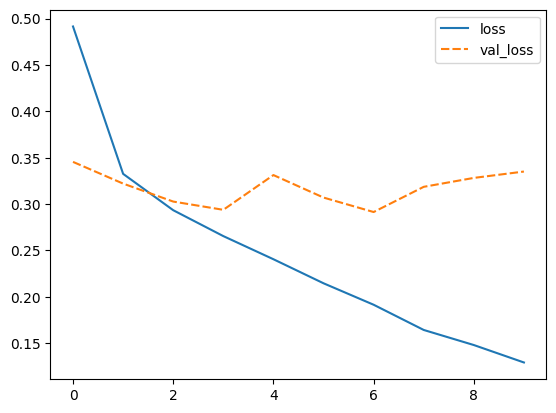

In [19]:
sns.lineplot(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})

<AxesSubplot: >

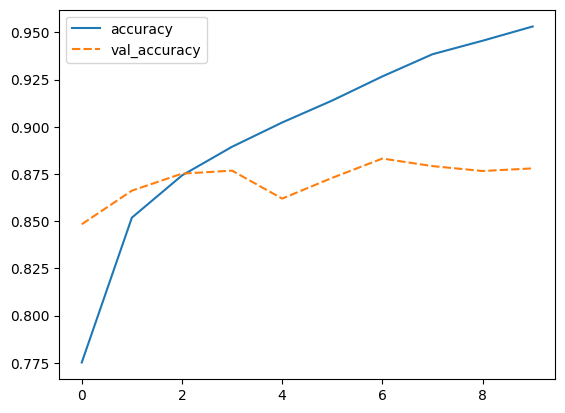

In [20]:
sns.lineplot(data={'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']})

In [21]:
model.load_weights('checkpoints/transformer.h5')

In [22]:
model.evaluate(int_test_ds)

782/782 [==============================] - 22s 28ms/step - loss: 0.3466 - accuracy: 0.8744


[0.3465568721294403, 0.8744000196456909]